# LSTM POS Tagger



## LSTM(Long-Short Term Memory)란?
![](https://i.ytimg.com/vi/nLPRvGogtrI/maxresdefault.jpg)

![](https://wikidocs.net/images/page/152773/2.JPG)


### 양방향 LSTM
![](https://files.codingninjas.in/article_images/bidirectional-lstm-2-1644656900.webp)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
torch.manual_seed(1)

In [3]:
bidirectional=False
lstm = nn.LSTM(3, 3, bidirectional=bidirectional,)  # Input dim is 3, output dim is 3
inputs = [torch.randn(1, 3) for _ in range(5)]  # make a sequence of length 5

# initialize the hidden state.
hidden_length = 2 if bidirectional else 1
initial_hidden = (torch.randn(hidden_length, 1, 3), torch.randn(hidden_length, 1, 3))

hidden = initial_hidden
for i in inputs:
    # Step through the sequence one element at a time.
    # after each step, hidden contains the hidden state.
    out, hidden = lstm(i.view(1, 1, -1), hidden)

print("for loop")
print(out)
print(hidden)

print("without for loop")
inputs = torch.stack(inputs)
out, hidden = lstm(inputs, initial_hidden)
print(out)
print(hidden)

for loop
tensor([[[-0.1371,  0.1054, -0.2518]]], grad_fn=<MkldnnRnnLayerBackward0>)
(tensor([[[-0.1371,  0.1054, -0.2518]]], grad_fn=<StackBackward0>), tensor([[[-0.3901,  0.2270, -0.3790]]], grad_fn=<StackBackward0>))
without for loop
tensor([[[ 0.0751, -0.0763, -0.1302]],

        [[-0.1326, -0.0100, -0.0764]],

        [[-0.1719,  0.0490,  0.0088]],

        [[-0.1924,  0.0459, -0.1917]],

        [[-0.1371,  0.1054, -0.2518]]], grad_fn=<MkldnnRnnLayerBackward0>)
(tensor([[[-0.1371,  0.1054, -0.2518]]], grad_fn=<StackBackward0>), tensor([[[-0.3901,  0.2270, -0.3790]]], grad_fn=<StackBackward0>))


## POS Tagging

In [ ]:
!pip install torchtext portalocker

In [5]:
import nltk
nltk.download('treebank')
nltk.download('universal_tagset')

tagged_sentence = nltk.corpus.treebank.tagged_sents(tagset='universal')
print("Number of Tagged Sentences ",len(tagged_sentence))

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


Number of Tagged Sentences  3914


In [6]:
# 데이터 살펴보기
print(tagged_sentence[:3][:10])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [7]:
def word_to_ix(word, ix):
    return torch.tensor(ix[word], dtype = torch.long)

def char_to_ix(char, ix):
    return torch.tensor(ix[char], dtype= torch.long)

def tag_to_ix(tag, ix):
    return torch.tensor(ix[tag], dtype= torch.long)

def sequence_to_idx(sequence, ix):
    return torch.tensor([ix[s] for s in sequence], dtype=torch.long)


word_to_idx = {}
tag_to_idx = {}
char_to_idx = {}
for sentence in tagged_sentence:
    for word, pos_tag in sentence:
        if word not in word_to_idx.keys():
            word_to_idx[word] = len(word_to_idx)
        if pos_tag not in tag_to_idx.keys():
            tag_to_idx[pos_tag] = len(tag_to_idx)
        for char in word:
            if char not in char_to_idx.keys():
                char_to_idx[char] = len(char_to_idx)

word_vocab_size = len(word_to_idx)
tag_vocab_size = len(tag_to_idx)
char_vocab_size = len(char_to_idx)

print("Unique words: {}".format(len(word_to_idx)))
print("Unique tags: {}".format(len(tag_to_idx)))
print("Unique characters: {}".format(len(char_to_idx)))

Unique words: 12408
Unique tags: 12
Unique characters: 79


In [8]:
import random

tr_random = random.sample(list(range(len(tagged_sentence))), int(0.95 * len(tagged_sentence)))

train = [tagged_sentence[i] for i in tr_random]
test = [tagged_sentence[i] for i in range(len(tagged_sentence)) if i not in tr_random]

In [9]:
# model hyperparameter
WORD_EMBEDDING_DIM = 1024
WORD_HIDDEN_DIM = 1024
EPOCHS = 70


### Embedding Layer
![](https://www.tensorflow.org/static/text/guide/images/embedding2.png)

In [10]:
class LSTMTagger(nn.Module):
    def __init__(self, word_embedding_dim, word_hidden_dim, word_vocab_size, tag_vocab_size):
        super().__init__()
        self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
        self.lstm = nn.LSTM(word_embedding_dim, word_hidden_dim)
        self.hidden2tag = nn.Linear(word_hidden_dim, tag_vocab_size)

    def forward(self, sentence):
        embeds = self.word_embedding(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))

        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [19]:
from tqdm.auto import trange,  tqdm

model = LSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, word_vocab_size, tag_vocab_size)
# model = BidirectionalLSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, word_vocab_size, tag_vocab_size)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if use_cuda:
    model.cuda()

# Define the loss function as the Negative Log Likelihood loss (NLLLoss)
loss_function = nn.NLLLoss()

# We will be using a simple SGD optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

print("Training Started")
accuracy_list = []
loss_list = []
interval = round(len(train) / 100.)
epochs = EPOCHS
e_interval = round(epochs / 10.)
for epoch in trange(epochs, position=0):
    acc = 0 #to keep track of accuracy
    loss = 0 # To keep track of the loss value
    i = 0

    for sentence_tag in tqdm(train, position=1, leave=False):
        i += 1
        # words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in sentence_tag]
        sentence = [s[0] for s in sentence_tag]
        sentence = torch.tensor(sequence_to_idx(sentence, word_to_idx), dtype=torch.long).to(device)
        targets = [s[1] for s in sentence_tag]
        targets = torch.tensor(sequence_to_idx(targets, tag_to_idx), dtype=torch.long).to(device)

        model.zero_grad()
        tag_scores = model(sentence)

        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        loss += loss.item()

        ################################
        # 구현: 정확도 계산 (acc.append (?))
        values, indices = tag_scores.topk(1)

        acc += (targets == indices.squeeze(1)).float().mean()
        if i % interval == 0:
            print("Epoch {} Running;\t{}% Complete".format(epoch + 1, i / interval), end = "\r", flush = True)
    loss = loss / len(train)
    acc = acc / len(train)
    loss_list.append(float(loss))
    accuracy_list.append(float(acc))
    if (epoch + 1) % e_interval == 0:
        print("Epoch {} Completed,\tLoss {}\tAccuracy: {}".format(epoch + 1, np.mean(loss_list[-e_interval:]), np.mean(accuracy_list[-e_interval:])))


Training Started


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

<ipython-input-19-b5fbae835397>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sentence = torch.tensor(sequence_to_idx(sentence, word_to_idx), dtype=torch.long).to(device)
<ipython-input-19-b5fbae835397>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(sequence_to_idx(targets, tag_to_idx), dtype=torch.long).to(device)


  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

Epoch 7 Completed,	Loss 0.0005184134518328522	Accuracy: 0.8264604806900024


  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

Epoch 14 Completed,	Loss 0.00046109028127310533	Accuracy: 0.8339461428778512


  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

Epoch 21 Completed,	Loss 0.0004144479607930407	Accuracy: 0.8306669592857361


  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

Epoch 28 Completed,	Loss 0.0004368760024330446	Accuracy: 0.8406451599938529


  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

Epoch 35 Completed,	Loss 0.000366320029050777	Accuracy: 0.8671665361949376


  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

Epoch 42 Completed,	Loss 0.0004565950283514602	Accuracy: 0.8973673582077026


  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

Epoch 49 Completed,	Loss 0.000411415339580604	Accuracy: 0.9065639546939305


  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

Epoch 56 Completed,	Loss 0.0003823809690532341	Accuracy: 0.9175391622952053


  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

Epoch 63 Completed,	Loss 0.0002477066861631881	Accuracy: 0.9269730619021824


  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

  0%|          | 0/3718 [00:00<?, ?it/s]

Epoch 70 Completed,	Loss 0.00035371470897059353	Accuracy: 0.9358396274702889


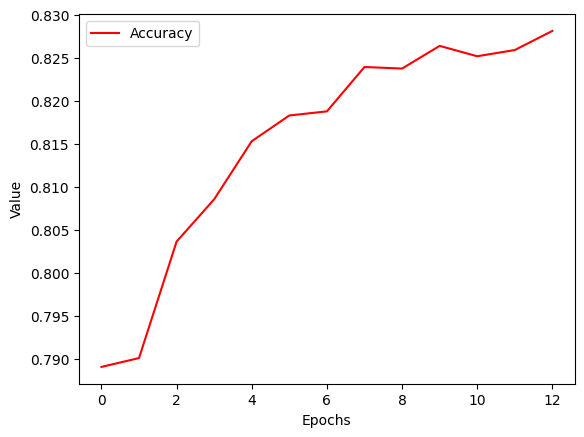

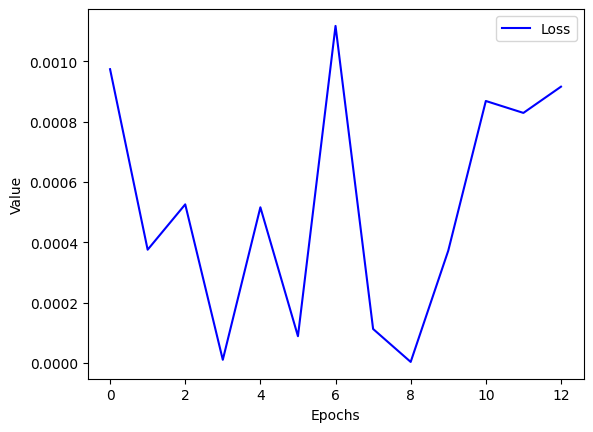

In [ ]:
import matplotlib.pyplot as plt
plt.plot(accuracy_list, c="red", label ="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

plt.plot(loss_list, c="blue", label ="Loss")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

## 양방향 LSTM

In [ ]:
class BidirectionalLSTMTagger(nn.Module):
    def __init__(self, word_embedding_dim, word_hidden_dim, word_vocab_size, tag_vocab_size):
        super().__init__()
        self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
        self.lstm = nn.LSTM(word_embedding_dim, word_hidden_dim, bidirectional=True)
        self.hidden2tag = nn.Linear(word_hidden_dim * 2, tag_vocab_size)

    def forward(self, sentence):
        embeds = self.word_embedding(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))

        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

## 직접 사용해보기

In [ ]:
test[0]

[('``', '.'),
 ('The', 'DET'),
 ('morbidity', 'NOUN'),
 ('rate', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('striking', 'ADJ'),
 ('finding', 'NOUN'),
 ('among', 'ADP'),
 ('those', 'DET'),
 ('of', 'ADP'),
 ('us', 'PRON'),
 ('who', 'PRON'),
 ('*T*-5', 'X'),
 ('study', 'VERB'),
 ('asbestos-related', 'ADJ'),
 ('diseases', 'NOUN'),
 (',', '.'),
 ("''", '.'),
 ('said', 'VERB'),
 ('*T*-1', 'X'),
 ('Dr.', 'NOUN'),
 ('Talcott', 'NOUN'),
 ('.', '.')]

In [ ]:
# test[0]
seq = [x[0] for x in test[0]]
with torch.no_grad():
    # words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in seq]
    sentence = torch.tensor(sequence_to_idx(seq, word_to_idx), dtype=torch.long).to(device)

    tag_scores = model(sentence)
    _, indices = torch.max(tag_scores, 1)
    ret = []
    for i in range(len(indices)):
        for key, value in tag_to_idx.items():
            if indices[i] == value:
                ret.append((seq[i], key))
    print(ret)

[('``', '.'), ('The', 'DET'), ('morbidity', 'NOUN'), ('rate', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('striking', 'ADJ'), ('finding', 'VERB'), ('among', 'ADP'), ('those', 'DET'), ('of', 'ADP'), ('us', 'PRON'), ('who', 'PRON'), ('*T*-5', 'NOUN'), ('study', 'VERB'), ('asbestos-related', 'NOUN'), ('diseases', 'NOUN'), (',', '.'), ("''", '.'), ('said', 'VERB'), ('*T*-1', 'X'), ('Dr.', 'NOUN'), ('Talcott', 'NOUN'), ('.', '.')]


<ipython-input-39-365f6f32390c>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sentence = torch.tensor(sequence_to_idx(seq, word_to_idx), dtype=torch.long).to(device)


# Reference
- https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html
- https://www.kaggle.com/code/krishanudb/lstm-character-word-pos-tag-model-pytorch

